# LeNeT for CIFAR10 Data Classification

In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import time

## Load Data

In [2]:
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
BatchSize = 100

trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170008576/170498071 [00:15<00:00, 9688967.58it/s]

Files already downloaded and verified


In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 50000
No. of samples in test set: 10000


## Define network architecture

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [5]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net = net.cuda()

GPU is available!


In [0]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam

## Train the network

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1 /20  ;  Training Loss: 0.012737 ; Testing Acc: 53.870 ; Time consumed: 0m 11s 
Iteration: 2 /20  ;  Training Loss: 0.012663 ; Testing Acc: 54.120 ; Time consumed: 0m 12s 
Iteration: 3 /20  ;  Training Loss: 0.012614 ; Testing Acc: 54.670 ; Time consumed: 0m 12s 
Iteration: 4 /20  ;  Training Loss: 0.012561 ; Testing Acc: 54.150 ; Time consumed: 0m 12s 
Iteration: 5 /20  ;  Training Loss: 0.012488 ; Testing Acc: 54.520 ; Time consumed: 0m 12s 
Iteration: 6 /20  ;  Training Loss: 0.012429 ; Testing Acc: 54.920 ; Time consumed: 0m 12s 
Iteration: 7 /20  ;  Training Loss: 0.012394 ; Testing Acc: 54.610 ; Time consumed: 0m 12s 
Iteration: 8 /20  ;  Training Loss: 0.012323 ; Testing Acc: 54.730 ; Time consumed: 0m 12s 
Iteration: 9 /20  ;  Training Loss: 0.012267 ; Testing Acc: 55.150 ; Time consumed: 0m 12s 
Iteration: 10 /20  ;  Training Loss: 0.012217 ; Testing Acc: 55.620 ; Time consumed: 0m 12s 
Iteration: 11 /20  ;  Training Loss: 0.012151 ; Testing Acc: 55.810 ; Time cons

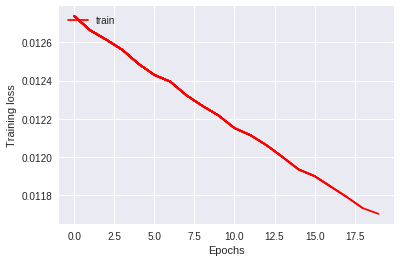

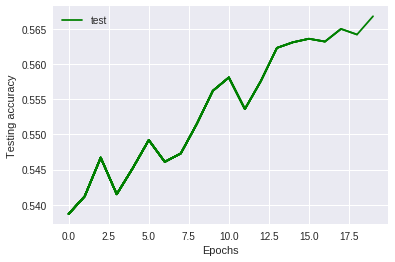

In [9]:
iterations = 20
trainLoss = []
testAcc = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network        
        outputs = net(inputs)        
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data  
    avgTrainLoss = runningLoss/50000.0
    trainLoss.append(avgTrainLoss)
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
        else:
            inputs = Variable(inputs)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum()
    avgTestAcc = float(running_correct)/10000.0
    testAcc.append(avgTestAcc)
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))
